## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [24]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from tqdm.notebook import tqdm
import time


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [25]:
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [26]:
download = True

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
train_transform = transform
test_transform = transform
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [27]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [28]:
len(fmnist_dataset_train)

60000

In [29]:
len(fmnist_dataset_test)

10000

In [30]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            # nn.Linear(input_shape, num_classes)
            nn.Linear(input_shape, input_shape//2),
            nn.BatchNorm1d(input_shape//2),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(input_shape//2, input_shape//3),
            nn.BatchNorm1d(input_shape//3),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            nn.Linear(input_shape//3, input_shape//4),
            nn.BatchNorm1d(input_shape//4),
            nn.ReLU(),
            nn.Linear(input_shape//4, num_classes),

        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
       BatchNorm1d-3                  [-1, 392]             784
              ReLU-4                  [-1, 392]               0
           Dropout-5                  [-1, 392]               0
            Linear-6                  [-1, 261]         102,573
       BatchNorm1d-7                  [-1, 261]             522
              Tanh-8                  [-1, 261]               0
           Dropout-9                  [-1, 261]               0
           Linear-10                  [-1, 196]          51,352
      BatchNorm1d-11                  [-1, 196]             392
             ReLU-12                  [-1, 196]               0
           Linear-13                   [-1, 10]           1,970
Total params: 465,313
Trainable params:

Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device, torch.float32)
opt = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_func = nn.CrossEntropyLoss()
num_epochs = 20
train_loss = []

# Your experiments, training and validation loops here

for epoch in range(num_epochs):
  for images, labels, in tqdm(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    # Zero out the gradients
    opt.zero_grad()

    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = loss_func(y, labels)
    # Backward pass
    loss.backward()
    opt.step()
  train_loss.append(loss.detach())



# Test
correct = 0
n_samples = 0

with torch.no_grad():
  # Iterate through test set minibatches
  for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)

    _, predictions = torch.max(y, 1)
    n_samples += labels.shape[0]
    correct += (predictions == labels).sum().item()

print('Test accuracy: {}'.format(100 * correct/n_samples))

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Test accuracy: 88.62


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [33]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            # nn.Linear(input_shape, num_classes)
            nn.Linear(input_shape, 740),
            # nn.BatchNorm1d(740),
            nn.ReLU(),
            # nn.Dropout(p=0.1),
            nn.Linear(740, 700),
            # nn.BatchNorm1d(700),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
            nn.Linear(700, 600),
            # nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Linear(600, 300),
            # nn.BatchNorm1d(300),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
            nn.Linear(300, 100),
            # nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, num_classes),

        )

    def forward(self, inp):
        out = self.model(inp)
        return out


In [34]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 740]         580,900
              ReLU-3                  [-1, 740]               0
            Linear-4                  [-1, 700]         518,700
              ReLU-5                  [-1, 700]               0
            Linear-6                  [-1, 600]         420,600
              ReLU-7                  [-1, 600]               0
            Linear-8                  [-1, 300]         180,300
              ReLU-9                  [-1, 300]               0
           Linear-10                  [-1, 100]          30,100
             ReLU-11                  [-1, 100]               0
           Linear-12                   [-1, 10]           1,010
Total params: 1,731,610
Trainable params: 1,731,610
Non-trainable params: 0
---------------------------

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_func = nn.CrossEntropyLoss()
num_epochs = 30

# initialize losses
losses    = torch.zeros(num_epochs)
trainAcc  = []
testAcc   = []

# Your experiments, come here

for epoch in range(num_epochs):
  batchAcc  = []
  batchLoss = []
  for images, labels, in tqdm(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    # Zero out the gradients
    opt.zero_grad()

    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = loss_func(y, labels)

    # Backward pass
    loss.backward()
    opt.step()

    # loss from this batch
    batchLoss.append(loss.item())

    # compute accuracy
    matches = torch.argmax(y,axis=1) == labels     # booleans (false/true)
    matchesNumeric = matches.float()             # convert to numbers (0/1)
    accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
    batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

  # now that we've trained through the batches, get their average training accuracy
  trainAcc.append( np.mean(batchAcc) )

  # and get average losses across the batches
  losses[epoch] = np.mean(batchLoss)

  # test accuracy
  X,y = next(iter(test_loader)) # extract X,y from test dataloader
  yHat = model(X)

  # compare the following really long line of code to the training accuracy lines
  testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )



  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

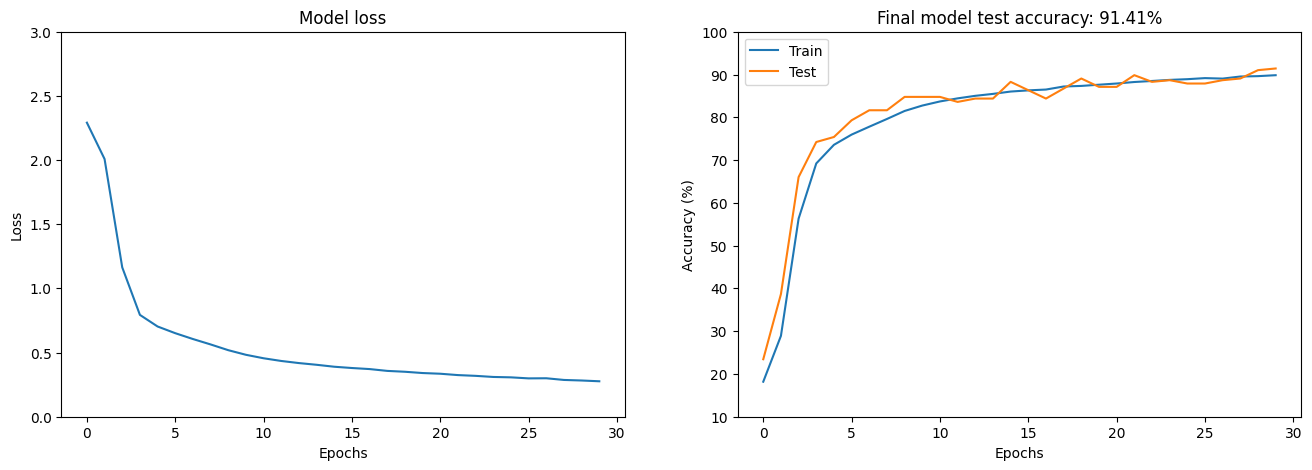

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

### **Давайте уменьшим модель в 3 раза**

In [ ]:
class OverfittingNeuralNetwork_small(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            # nn.Linear(input_shape, num_classes)
            nn.Linear(input_shape, 150),
            # nn.BatchNorm1d(740),
            nn.ReLU(),
            # nn.Dropout(p=0.1),
            nn.Linear(150, num_classes),

        )

    def forward(self, inp):
        out = self.model(inp)
        return out


In [ ]:
model = OverfittingNeuralNetwork_small().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_func = nn.CrossEntropyLoss()
num_epochs = 30

# initialize losses
losses    = torch.zeros(num_epochs)
trainAcc  = []
testAcc   = []

# Your experiments, come here

for epoch in range(num_epochs):
  batchAcc  = []
  batchLoss = []
  for images, labels, in tqdm(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    # Zero out the gradients
    opt.zero_grad()

    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = loss_func(y, labels)

    # Backward pass
    loss.backward()
    opt.step()

    # loss from this batch
    batchLoss.append(loss.item())

    # compute accuracy
    matches = torch.argmax(y,axis=1) == labels     # booleans (false/true)
    matchesNumeric = matches.float()             # convert to numbers (0/1)
    accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
    batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

  # now that we've trained through the batches, get their average training accuracy
  trainAcc.append( np.mean(batchAcc) )

  # and get average losses across the batches
  losses[epoch] = np.mean(batchLoss)

  # test accuracy
  X,y = next(iter(test_loader)) # extract X,y from test dataloader
  yHat = model(X)

  # compare the following really long line of code to the training accuracy lines
  testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

# end epochs


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

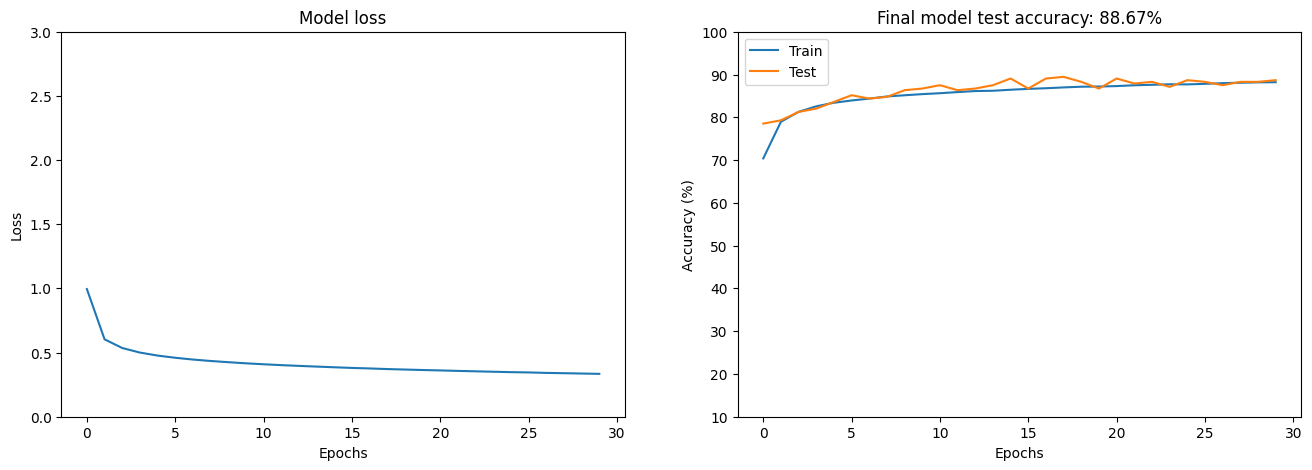

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

### Уменьшим размер обучающей выборки с 60000 до 1000

In [49]:
part_tr = torch.utils.data.random_split(fmnist_dataset_train, [1000, len(fmnist_dataset_train)-1000])[0]

train_loader = torch.utils.data.DataLoader(part_tr,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)
len(part_tr)

1000

In [50]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_func = nn.CrossEntropyLoss()
num_epochs = 30

# initialize losses
losses    = torch.zeros(num_epochs)
trainAcc  = []
testAcc   = []

# Your experiments, come here

for epoch in range(num_epochs):
  batchAcc  = []
  batchLoss = []
  for images, labels, in tqdm(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    # Zero out the gradients
    opt.zero_grad()

    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = loss_func(y, labels)

    # Backward pass
    loss.backward()
    opt.step()

    # loss from this batch
    batchLoss.append(loss.item())

    # compute accuracy
    matches = torch.argmax(y,axis=1) == labels     # booleans (false/true)
    matchesNumeric = matches.float()             # convert to numbers (0/1)
    accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
    batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

  # now that we've trained through the batches, get their average training accuracy
  trainAcc.append( np.mean(batchAcc) )

  # and get average losses across the batches
  losses[epoch] = np.mean(batchLoss)

  # test accuracy
  X,y = next(iter(test_loader)) # extract X,y from test dataloader
  yHat = model(X)

  # compare the following really long line of code to the training accuracy lines
  testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

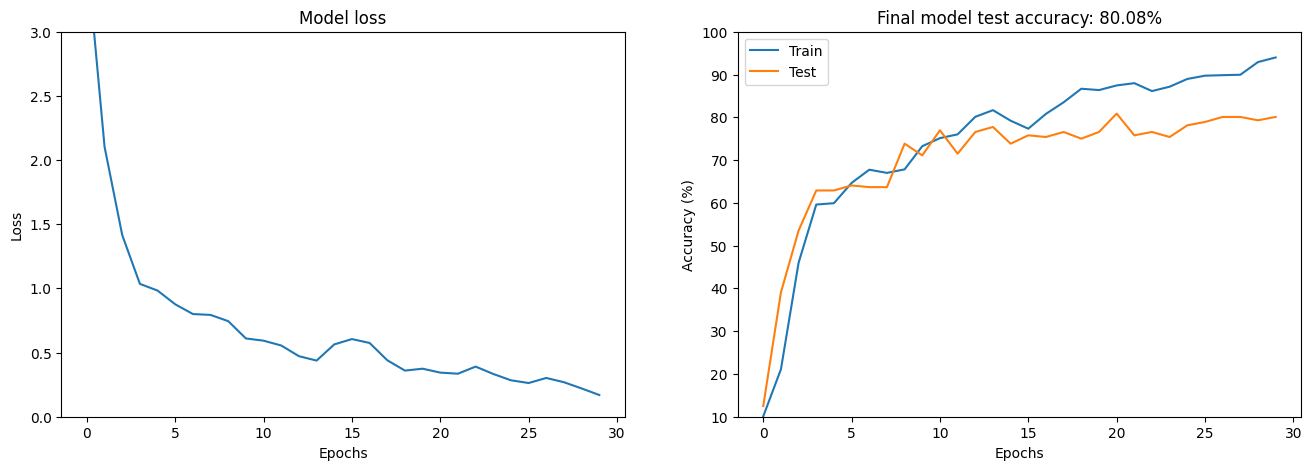

In [51]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

Наиболее ярко видно перееобучение, когда обучающая выборка у нас всего 1000. Попробуем этот вопрос решить именно для такой обучающей выборки.

In [52]:
part_tr = torch.utils.data.random_split(fmnist_dataset_train, [1000, len(fmnist_dataset_train)-1000])[0]

train_loader = torch.utils.data.DataLoader(part_tr,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)
len(part_tr)

1000

In [61]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            # nn.Linear(input_shape, num_classes)
            nn.Linear(input_shape, 700),
            nn.BatchNorm1d(700),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(700, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(500, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(300, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, num_classes),

        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [62]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 700]         549,500
       BatchNorm1d-3                  [-1, 700]           1,400
              ReLU-4                  [-1, 700]               0
           Dropout-5                  [-1, 700]               0
            Linear-6                  [-1, 500]         350,500
       BatchNorm1d-7                  [-1, 500]           1,000
              ReLU-8                  [-1, 500]               0
           Dropout-9                  [-1, 500]               0
           Linear-10                  [-1, 400]         200,400
      BatchNorm1d-11                  [-1, 400]             800
             ReLU-12                  [-1, 400]               0
           Linear-13                  [-1, 300]         120,300
      BatchNorm1d-14                  [

In [63]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_func = nn.CrossEntropyLoss()
num_epochs = 30

# initialize losses
losses    = torch.zeros(num_epochs)
trainAcc  = []
testAcc   = []

# Your experiments, come here

for epoch in range(num_epochs):
  batchAcc  = []
  batchLoss = []
  for images, labels, in tqdm(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    # Zero out the gradients
    opt.zero_grad()

    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = loss_func(y, labels)

    # Backward pass
    loss.backward()
    opt.step()

    # loss from this batch
    batchLoss.append(loss.item())

    # compute accuracy
    matches = torch.argmax(y,axis=1) == labels     # booleans (false/true)
    matchesNumeric = matches.float()             # convert to numbers (0/1)
    accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
    batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

  # now that we've trained through the batches, get their average training accuracy
  trainAcc.append( np.mean(batchAcc) )

  # and get average losses across the batches
  losses[epoch] = np.mean(batchLoss)

  # test accuracy
  X,y = next(iter(test_loader)) # extract X,y from test dataloader
  yHat = model(X)

  # compare the following really long line of code to the training accuracy lines
  testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

# end epochs


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

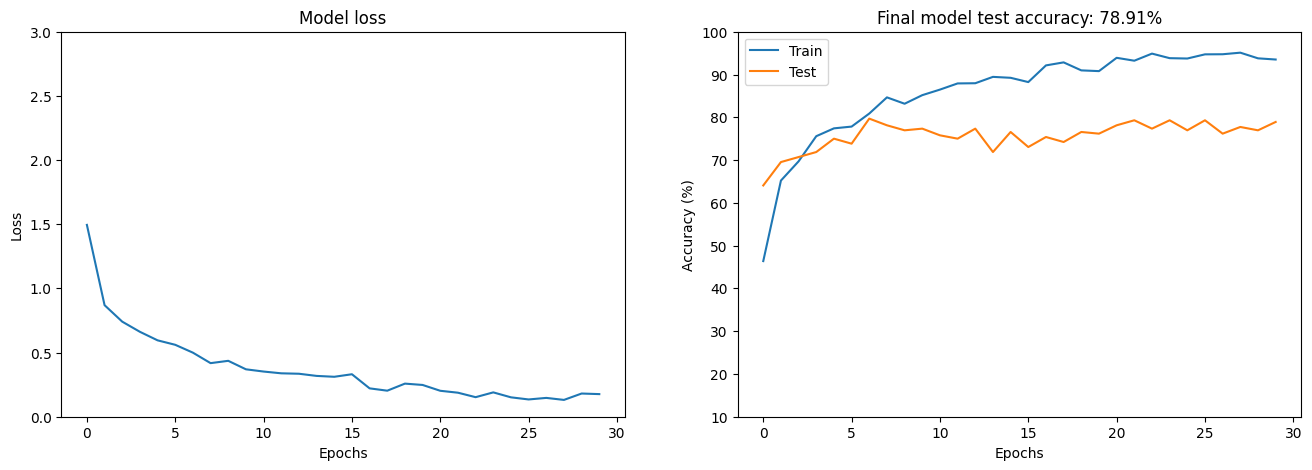

In [64]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

### Возвращаемся к изначальному количеству данных

In [65]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)
len(fmnist_dataset_train)

60000

In [66]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_func = nn.CrossEntropyLoss()
num_epochs = 35

# initialize losses
losses    = torch.zeros(num_epochs)
trainAcc  = []
testAcc   = []

# Your experiments, come here

for epoch in range(num_epochs):
  batchAcc  = []
  batchLoss = []
  for images, labels, in tqdm(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    # Zero out the gradients
    opt.zero_grad()

    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = loss_func(y, labels)

    # Backward pass
    loss.backward()
    opt.step()

    # loss from this batch
    batchLoss.append(loss.item())

    # compute accuracy
    matches = torch.argmax(y,axis=1) == labels     # booleans (false/true)
    matchesNumeric = matches.float()             # convert to numbers (0/1)
    accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
    batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

  # now that we've trained through the batches, get their average training accuracy
  trainAcc.append( np.mean(batchAcc) )

  # and get average losses across the batches
  losses[epoch] = np.mean(batchLoss)

  # test accuracy
  X,y = next(iter(test_loader)) # extract X,y from test dataloader
  yHat = model(X)

  # compare the following really long line of code to the training accuracy lines
  testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

# end epochs


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

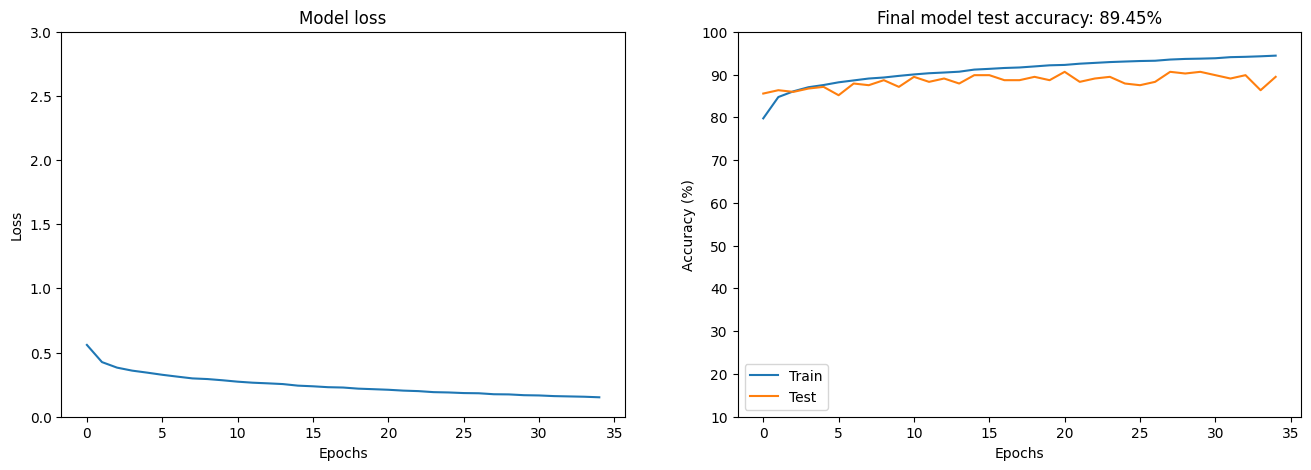

In [67]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

Все эти эксперименты показали, что ключевым вопросом по получению высоких результатов модели - это наличие большого количества обучающих данных. Если их мало, то переобучения происходит практически сразу и мы видим, что кривая обучения идет вверх(accuracy растет вверх), а кривая тестирования начинает довольно быстро снижаться, что говорит о переобучении. Недостататок данных, если он совсем маленький (как у нас было 1000 объектов) практически невозможно ничем компенсировать.

Количество слоев тоже влияет на переобучаемость модели. Чем больше слоев, тем больше переобучение. Но в этих экспериментах большой разницы в переобучении я не наблюдал.

Если говорить про нормализацию данных, то да повышается устойчивость прогнозов, быстрее обучается модель. Дропаут до уровня 0,3 повышает обобщающую способность модели, но если им сильно увлечься, то сильно понижается accuracy модели.  